In [1]:
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
# from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import pickle
import joblib
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [3]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from IPython.display import display
import os
directory=os.getcwd().replace('notebooks','data\\output\\census_elections\\')
filename="census_election_totals_and_percent_data.csv"
full_name=f"{directory}{filename}"
output_directory=directory.replace('\\output\\census_elections\\','\\output\\model_output\\')
# CV_feat_importances_df=pd.read_csv(f'{output_directory}CV_percent_feat_importances_df.csv')
CV_feat_importances_df=pd.read_csv(f'{output_directory}CV_feat_importances_df.csv')

important_columns=list(CV_feat_importances_df.nlargest(150,'score')['fields'])
full_df=pd.read_csv(full_name).set_index(['District_Name_x','Electoral_District_Number'])
del full_df['employment_employed']
del full_df['employment_unemployed']
del full_df['employment_not_in_the_labour_force']
del full_df['District_Name_y']
# del full_df['District_Name_x']
del full_df['employment_employment_rate']
del full_df['employment_participation_rate']
del full_df['ALT_GEO_CODE_y']
del full_df['ALT_GEO_CODE_x']

full_df2=full_df
full_df2=full_df
y3 = full_df2['employment_unemployment_rate']
categorical_fields=full_df2.select_dtypes(include='object').columns
full_df2=pd.get_dummies(data=full_df2,columns=categorical_fields,drop_first=True)
corr_matrix = full_df2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

# Drop features 
full_df2=full_df2.drop(to_drop, axis=1)
try:
    X2 = full_df2.drop('employment_unemployment_rate',1).fillna(0)
except KeyError:
    X2=full_df2
X2 = X2.loc[:, X2.columns.isin(important_columns)].filter(regex='percent')
# X2=X2.drop(['2015_Other_Votes','2015-2019_EOE_Percent_Change_Green-Party_Votes','2015_NDP-New-Democratic-Party_Votes','2015_Conservative_Votes','2015-2019_Absolute_Change_Conservative'],1)
print(X2.shape)
#Select top 2 features based on mutual info regression
selector = SelectKBest(mutual_info_regression, k =17)
selector.fit(X2, y3)
X3=X2[X2.columns[selector.get_support()]]
display(calc_vif(X3).sort_values('VIF').reset_index().head(50))
X3 = sm.add_constant(X3) # adding a constant

model = sm.OLS(y3/100, X3).fit()
predictions = model.predict(X3) 

print_model = model.summary()
display(print_model)
results_as_html = print_model.tables[1].as_html()
results_df=pd.read_html(results_as_html, header=0, index_col=0)[0]
results_df.index.name = 'variable'
results_df=results_df.reset_index()
results_df2=results_df[results_df['P>|t|'] <= 0.05]
columns=list(results_df2['variable'])
columns.remove('const')
columns

C:\Users\Chike\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(338, 35)


,index,variables,VIF
0,8,home_ownership_percent_band_housing,1.293017
1,13,industry_percent_mining_quarrying_and_oil_and_...,1.934093
2,3,ethnic_percent_korean,2.092862
3,4,ethnic_percent_japanese,2.900306
4,2,ethnic_percent_southeast_asian,3.062238
5,1,ethnic_percent_black,4.257447
6,16,immigration_arrival_percent_before_1981,16.191712
7,14,industry_percent_wholesale_trade,17.860837
8,9,marital_status_percent_separated,26.943009
9,6,age_percent_25_to_29_years,31.848908


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     employment_unemployment_rate   R-squared:                       0.559
Model:                                      OLS   Adj. R-squared:                  0.536
Method:                           Least Squares   F-statistic:                     23.89
Date:                          Sun, 26 Sep 2021   Prob (F-statistic):           4.58e-47
Time:                                  19:31:29   Log-Likelihood:                 860.18
No. Observations:                           338   AIC:                            -1684.
Df Residuals:                               320   BIC:                            -1616.
Df Model:                                    17                                         
Covariance Type:                      nonrobust                                         
=========================================================================================================================================================
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                     0.2865      0.050      5.679      0.000       0.187       0.386
employment_type_percent_0_management_occupations                                         -0.4329      0.059     -7.287      0.000      -0.550      -0.316
ethnic_percent_black                                                                      0.1559      0.044      3.556      0.000       0.070       0.242
ethnic_percent_southeast_asian                                                           -0.0637      0.138     -0.462      0.644      -0.335       0.207
ethnic_percent_korean                                                                     0.2093      0.141      1.481      0.140      -0.069       0.487
ethnic_percent_japanese                                                                  -1.2070      0.407     -2.965      0.003      -2.008      -0.406
age_percent_20_to_24_years                                                               -0.3265      0.129     -2.525      0.012      -0.581      -0.072
age_percent_25_to_29_years                                                               -0.2676      0.090     -2.960      0.003      -0.446      -0.090
age_percent_55_to_59_years                                                               -0.0167      0.186     -0.090      0.928      -0.382       0.348
home_ownership_percent_band_housing                                                       0.0830      0.052      1.611      0.108      -0.018       0.184
marital_status_percent_separated                                                          0.4130      0.229      1.800      0.073      -0.038       0.864
married_lone_parent_percent_total_couple_families                                        -0.0599      0.053     -1.122      0.263      -0.165       0.045
employee_departure_time_percent_between_6_a.m._and_6:59_a.m.                             -0.3011      0.036     -8.415      0.000      -0.372      -0.231
employee_departure_time_percent_between_7_a.m._and_7:59_a.m.                             -0.0276      0.035     -0.795      0.427      -0.096       0.041
industry_percent_mining_quarrying_and_oil_and_gas_extraction                              0.3340      0.045      7.377      0.000       0.245       0.423
industry_percent_wholesale_trade                                                         -0.3090      0.120     -2.576      0.010      -0.545      -0.073
industry_percent_administrative_and_support_was

['employment_type_percent_0_management_occupations',
 'ethnic_percent_black',
 'ethnic_percent_japanese',
 'age_percent_20_to_24_years',
 'age_percent_25_to_29_years',
 'employee_departure_time_percent_between_6_a.m._and_6:59_a.m.',
 'industry_percent_mining_quarrying_and_oil_and_gas_extraction',
 'industry_percent_wholesale_trade',
 'industry_percent_administrative_and_support_waste_management_and_remediation_services']

In [4]:
pd.options.display.max_columns = None
scaler = StandardScaler()
feats=X2[columns].nlargest(80,'ethnic_percent_black')
feats_scaled = scaler.fit_transform(feats)
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42).fit(feats_scaled)
feats['cluster']=kmeans.predict(feats_scaled)

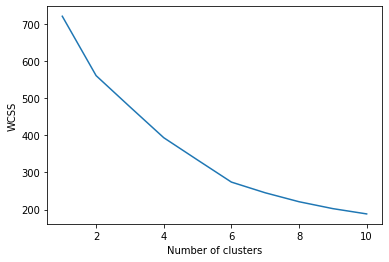

In [5]:
from sklearn.cluster import KMeans
wcss = [] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(feats_scaled) 
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

In [6]:
feats.groupby(['cluster']).mean()

,employment_type_percent_0_management_occupations,ethnic_percent_black,ethnic_percent_japanese,age_percent_20_to_24_years,age_percent_25_to_29_years,employee_departure_time_percent_between_6_a.m._and_6:59_a.m.,industry_percent_mining_quarrying_and_oil_and_gas_extraction,industry_percent_wholesale_trade,industry_percent_administrative_and_support_waste_management_and_remediation_services
cluster,,,,,,,,,
0,0.078028,0.162832,0.001307,0.071259,0.066104,0.189066,0.000839,0.047624,0.069052
1,0.102020,0.070961,0.001701,0.069132,0.068863,0.170507,0.001542,0.042007,0.051448
2,0.140663,0.067595,0.005314,0.105008,0.148614,0.081131,0.002300,0.031370,0.040858
3,0.073039,0.078236,0.001197,0.067894,0.080490,0.211818,0.025117,0.038895,0.055053
4,0.128596,0.066906,0.005824,0.060321,0.074822,0.119706,0.001344,0.033735,0.051100


In [7]:
feats.cluster.value_counts()

1    43
0    17
4    11
3     5
2     4
Name: cluster, dtype: int64

In [8]:
feats

,,employment_type_percent_0_management_occupations,ethnic_percent_black,ethnic_percent_japanese,age_percent_20_to_24_years,age_percent_25_to_29_years,employee_departure_time_percent_between_6_a.m._and_6:59_a.m.,industry_percent_mining_quarrying_and_oil_and_gas_extraction,industry_percent_wholesale_trade,industry_percent_administrative_and_support_waste_management_and_remediation_services,cluster
District_Name_x,Electoral_District_Number,,,,,,,,,,
Bourassa,24015,0.059050,0.239871,0.000153,0.059880,0.060029,0.200288,0.000583,0.043762,0.080173,0
Etobicoke North,35029,0.057114,0.234012,0.001240,0.080862,0.073026,0.190447,0.000547,0.041724,0.077708,0
York South--Weston,35120,0.066891,0.232085,0.002562,0.068518,0.068775,0.202388,0.000973,0.035566,0.085110,0
Humber River--Black Creek,35121,0.050746,0.228034,0.001160,0.083167,0.073911,0.205396,0.000823,0.040350,0.080700,0
Brampton West,35012,0.090949,0.188572,0.000657,0.066654,0.066192,0.199514,0.001381,0.052272,0.057506,0
...,...,...,...,...,...,...,...,...,...,...,...
Oshawa,35074,0.083320,0.047121,0.001198,0.067093,0.068197,0.200839,0.000966,0.036873,0.064327,1
Châteauguay--Lacolle,24021,0.102501,0.046625,0.000155,0.061450,0.055831,0.222948,0.002560,0.048444,0.042143,1
Saint Boniface--Saint Vital,46009,0.103211,0.045193,0.003301,0.064522,0.068808,0.171691,0.002058,0.035093,0.035916,1


In [9]:
feats2=feats.reset_index()#.set_index(['cluster','Electoral_District_Number'])
feats2=feats2[['Electoral_District_Number','cluster']]
feats2

,Electoral_District_Number,cluster
0,24015,0
1,35029,0
2,35120,0
3,35121,0
4,35012,0
...,...,...
75,35074,1
76,24021,1
77,46009,1
78,12004,1


In [10]:
main_df=full_df.reset_index()
main_df=main_df.merge(feats2,how='left',on='Electoral_District_Number').set_index('Electoral_District_Number')
main_df.cluster=main_df.cluster.fillna(5)
analyze_main_df=main_df.groupby(['cluster']).mean().reset_index()

In [15]:
analyze_main_df

,cluster,2015_Bloc-Québécois_Votes,2015_Conservative_Votes,2015_Green-Party_Votes,2015_Liberal_Votes,2015_NDP-New-Democratic-Party_Votes,2015_Other_Votes,2015_Vote_Total,2015_Number_of_Polling_Stations,2015_Number_of_Electors,2015_Bloc-Québécois,2015_Conservative,2015_Green-Party,2015_Liberal,2015_NDP-New-Democratic-Party,2015_Other,2015_Percent_Riding_Votes_Liberal,2015_Percent_Riding_Votes_Bloc-Québécois,2015_Percent_Riding_Votes_Conservative,2015_Percent_Riding_Votes_Green-Party,2015_Percent_Riding_Votes_NDP-New-Democratic-Party,2015_Percent_Riding_Votes_Other,2015_Voter_Participation,2019_Bloc-Québécois_Votes,2019_Conservative_Votes,2019_Green-Party_Votes,2019_Liberal_Votes,2019_NDP-New-Democratic-Party_Votes,2019_Other_Votes,2019_Vote_Total,2019_Number_of_Polling_Stations,2019_Number_of_Electors,2019_Bloc-Québécois,2019_Conservative,2019_Green-Party,2019_Liberal,2019_NDP-New-Democratic-Party,2019_Other,2019_Percent_Riding_Votes_Liberal,2019_Percent_Riding_Votes_Bloc-Québécois,2019_Percent_Riding_Votes_Conservative,2019_Percent_Riding_Votes_Green-Party,2019_Percent_Riding_Votes_NDP-New-Democratic-Party,2019_Percent_Riding_Votes_Other,2019_Voter_Participation,2015-2019_Absolute_Change_Bloc-Québécois_Votes,2015-2019_EOE_Percent_Change_Bloc-Québécois_Votes,2015-2019_Absolute_Change_Conservative_Votes,2015-2019_EOE_Percent_Change_Conservative_Votes,2015-2019_Absolute_Change_Green-Party_Votes,2015-2019_EOE_Percent_Change_Green-Party_Votes,2015-2019_Absolute_Change_Liberal_Votes,2015-2019_EOE_Percent_Change_Liberal_Votes,2015-2019_Absolute_Change_NDP-New-Democratic-Party_Votes,2015-2019_EOE_Percent_Change_NDP-New-Democratic-Party_Votes,2015-2019_Absolute_Change_Other_Votes,2015-2019_EOE_Percent_Change_Other_Votes,2015-2019_Absolute_Change_Vote_Total,2015-2019_EOE_Percent_Change_Vote_Total,2015-2019_Absolute_Change_Number_of_Polling_Stations,2015-2019_EOE_Percent_Change_Number_of_Polling_Stations,2015-2019_Absolute_Change_Number_of_Electors,2015-2019_EOE_Percent_Change_Number_of_Electors,2015-2019_Absolute_Change_Bloc-Québécois,2015-2019_EOE_Percent_Change_Bloc-Québécois,2015-2019_Absolute_Change_Conservative,2015-2019_EOE_Percent_Change_Conservative,2015-2019_Absolute_Change_Green-Party,2015-2019_EOE_Percent_Change_Green-Party,2015-2019_Absolute_Change_Liberal,2015-2019_EOE_Percent_Change_Liberal,2015-2019_Absolute_Change_NDP-New-Democratic-Party,2015-2019_EOE_Percent_Change_NDP-New-Democratic-Party,2015-2019_Absolute_Change_Other,2015-2019_EOE_Percent_Change_Other,2015-2019_Absolute_Change_Percent_Riding_Votes_Liberal,2015-2019_EOE_Percent_Change_Percent_Riding_Votes_Liberal,2015-2019_Absolute_Change_Percent_Riding_Votes_Bloc-Québécois,2015-2019_EOE_Percent_Change_Percent_Riding_Votes_Bloc-Québécois,2015-2019_Absolute_Change_Percent_Riding_Votes_Conservative,2015-2019_EOE_Percent_Change_Percent_Riding_Votes_Conservative,2015-2019_Absolute_Change_Percent_Riding_Votes_Green-Party,2015-2019_EOE_Percent_Change_Percent_Riding_Votes_Green-Party,2015-2019_Absolute_Change_Percent_Riding_Votes_NDP-New-Democratic-Party,2015-2019_EOE_Percent_Change_Percent_Riding_Votes_NDP-New-Democratic-Party,2015-2019_Absolute_Change_Percent_Riding_Votes_Other,2015-2019_EOE_Percent_Change_Percent_Riding_Votes_Other,2015-2019_Absolute_Change_Voter_Participation,2015-2019_EOE_Percent_Change_Voter_Participation,employment_type_percent_0_management_occupations,employment_type_percent_1_business_finance_and_administration_occupations,employment_type_percent_2_natural_and_applied_sciences_and_related_occupations,employment_type_percent_3_health_occupations,employment_type_percent_4_occupations_in_education_law_and_social_community_and_government_services,employment_type_percent_5_occupations_in_art_culture_recreation_and_sport,employment_type_percent_6_sales_and_service_occupations,employment_type_percent_7_trades_transport_and_equipment_operators_and_related_occupations,employment_type_percent_8_natural_resources_agriculture_and_related_production_occupation

In [16]:
main_df.cluster.value_counts()

5.0    258
1.0     43
0.0     17
4.0     11
3.0      5
2.0      4
Name: cluster, dtype: int64

In [12]:
output_directory=directory.replace('\\output\\census_elections\\','\\processed\\')
main_df.to_csv(f'{output_directory}main_df.csv')
analyze_main_df.to_csv(f'{output_directory}analyze_main_df.csv')